# Introduction to pyvene
This tutorial shows simple runnable code snippets of how to do different kinds of interventions on neural networks with pyvene.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/stanfordnlp/pyvene/blob/main/pyvene_101.ipynb)

In [1]:
__author__ = "Zhengxuan Wu"
__version__ = "01/20/2024"

 # Table of Contents  
1. [Set-up](#Set-up)     
1. [pyvene 101](#pyvene-101) 
    1. [Get Attention Weights](#Get-Attention-Weights)
    1. [Set Activations to Zeros](#Set-Activation-to-Zeros) 
    1. [Set Activations with Subspaces](#Set-Activations-to-Zeros-with-Subspaces)
    1. [Interchange Intervention](#Interchange-Interventions)
    1. [Intervention Config](#Intervention-Configuration)
    1. [Addition Intervention](#Addition-Intervention)
    1. [Trainable Intervention](#Trainable-Intervention)
    1. [Activation Collection](#Activation-Collection-with-Intervention)
    1. [Activation Collection with Other Intervention](#Activation-Collection-at-Downstream-of-a-Intervened-Model)
    1. [Intervene Single Neuron](#Intervene-on-a-Single-Neuron)
    1. [Add New Intervention Type](#Add-New-Intervention-Type)
    1. [Intervene on Recurrent NNs](#Recurrent-NNs-(Intervene-a-Specific-Timestep))
    1. [Intervene across Times with RNNs](#Recurrent-NNs-(Intervene-cross-Time))
    1. [Intervene on LM Generation](#LMs-Generation)
    1. [Debiasing with Backpack LMs](#Debiasing-with-Backpack-LMs)
    1. [Saving and Loading](#Saving-and-Loading)
    1. [Multi-Source Intervention (Parallel)](#Multi-Source-Interchange-Intervention-(Parallel-Mode))
    1. [Multi-Source Intervention (Serial)](#Multi-Source-Interchange-Intervention-(Serial-Mode))
    1. [Multi-Source Intervention with Subspaces (Parallel)](#Multi-Source-Interchange-Intervention-with-Subspaces-(Parallel-Mode))
    1. [Multi-Source Intervention with Subspaces (Serial)](#Multi-Source-Interchange-Intervention-with-Subspaces-(Serial-Mode))
    1. [Interchange Intervention Training](#Interchange-Intervention-Training-(IIT))
1. [pyvene 102](#pyvene-102)
    1. [Intervention Grouping](#Grouping)
    1. [Intervention Skipping](#Intervention-Skipping-in-Runtime)
    1. [Subspace Partition](#Subspace-Partition)
    1. [Intervention Linking](#Intervention-Linking)
    1. [Add New Model Type](#Add-New-Model-Type)
    1. [Path Patching](#Composing-Complex-Intervention-Schema:-Path-Patching)
    1. [Causal Tracing](#Composing-Complex-Intervention-Schema:-Causal-Tracing-in-15-lines)
1. [The End](#The-End)
    

## Set-up

In [ ]:
try:
    # This library is our indicator that the required installs
    # need to be done.
    import pyvene

except ModuleNotFoundError:
    !pip install git+https://github.com/stanfordnlp/pyvene.git

## pyvene 101
Before we get started, here are a couple of core notations that are used in this library:
- **Base** example: this is the example we are intervening on, or, we are intervening on the computation graph of the model running the **Base** example.
- **Source** example or representations: this is the source of our intervention. We use **Source** to intervene on **Base**.
- **component**: this is the `nn.module` we are intervening in a pytorch-based NN.
- **unit**: this is the axis of our intervention. If we say our **unit** is `pos` (`position`), then you are intervening on each token position.
- **unit_locations**: this list gives you the percisely location of your intervention. It is the locations of the unit of analysis you are specifying. For instance, if your `unit` is `pos`, and your `unit_location` is 3, then it means you are intervening on the third token.

### Get Attention Weights

In [24]:
import pyvene as pv
from circuitsvis.attention import attention_patterns

_, tokenizer, gpt2 = pv.create_gpt2()

pv_gpt2 = pv.IntervenableModel({
    "layer": 10,
    "component": "attention_weight",
    "intervention_type": pv.CollectIntervention}, model=gpt2)

base = "When John and Mary went to the shops, Mary gave the bag to"
collected_attn_w = pv_gpt2(
    base = tokenizer(base, return_tensors="pt"
    ), unit_locations={"base": ([[[h for h in range(12)]]])}
)[0][-1][0]

loaded model


In [26]:
attention_patterns(tokens=tokenizer.tokenize(base), attention=collected_attn_w)

### Set Activation to Zeros

In [3]:
import torch
import pyvene as pv

_, tokenizer, gpt2 = pv.create_gpt2()

# define the component to zero-out
pv_gpt2 = pv.IntervenableModel({
    "layer": 0, "component": "mlp_output",
    "source_representation": torch.zeros(gpt2.config.n_embd)
}, model=gpt2)
# run the intervened forward pass
intervened_outputs = pv_gpt2(
    base = tokenizer("The capital of Spain is", return_tensors="pt"), 
    # we define the intervening token dynamically
    unit_locations={"base": 3}
)

loaded model


### Set Activations to Zeros with Subspaces
The notion of subspace means the actual dimensions you are intervening. If we have a representation in a size of 512, the first 128 activation values are its subspace activations.

In [4]:
import torch
import pyvene as pv
# built-in helper to get a HuggingFace model
_, tokenizer, gpt2 = pv.create_gpt2()
# create with dict-based config
pv_config = pv.IntervenableConfig({
  "layer": 0, "component": "mlp_output"})
#initialize model
pv_gpt2 = pv.IntervenableModel(pv_config, model=gpt2)
# run an intervened forward pass
intervened_outputs = pv_gpt2(
  # the intervening base input
  base=tokenizer("The capital of Spain is", return_tensors="pt"), 
  # the location to intervene at (3rd token)
  unit_locations={"base": 3},
  # the individual dimensions targetted
  subspaces=[10,11,12],
  source_representations=torch.zeros(gpt2.config.n_embd)
)
# sharing
pv_gpt2.save("./tmp/")

loaded model
Directory './tmp/' already exists.


### Interchange Interventions
Instead of a static vector, we can intervene the model with activations sampled from a different forward run. We call this interchange intervention, where intervention happens between two examples and we are interchanging activations between them.

In [6]:
import torch
import pyvene as pv
# built-in helper to get a HuggingFace model
_, tokenizer, gpt2 = pv.create_gpt2()
# create with dict-based config
pv_config = pv.IntervenableConfig({
  "layer": 0,
  "component": "mlp_output"},
  intervention_types=pv.VanillaIntervention
)
#initialize model
pv_gpt2 = pv.IntervenableModel(
  pv_config, model=gpt2)
# run an interchange intervention 
intervened_outputs = pv_gpt2(
  # the base input
  base=tokenizer(
    "The capital of Spain is", 
    return_tensors = "pt"), 
  # the source input
  sources=tokenizer(
    "The capital of Italy is", 
    return_tensors = "pt"), 
  # the location to intervene at (3rd token)
  unit_locations={"sources->base": 3},
  # the individual dimensions targeted
  subspaces=[10,11,12]
)

loaded model


### Intervention Configuration
You can also initialize the config without the lazy dictionary passing by enabling more options, e.g., the mode of these interventions are executed.

In [4]:
import torch
import pyvene as pv

_, tokenizer, gpt2 = pv.create_gpt2()
# standalone configuration object
config = pv.IntervenableConfig([
    {
        "layer": _,
        "component": "mlp_output",
        "source_representation": torch.zeros(
            gpt2.config.n_embd)
    } for _ in range(4)],
    mode="parallel"
)
# this object is serializable
print(config)
pv_gpt2 = pv.IntervenableModel(config, model=gpt2)

intervened_outputs = pv_gpt2(
    base = tokenizer("The capital of Spain is", return_tensors="pt"), 
    unit_locations={"base": 3}
)

loaded model
IntervenableConfig
{
    "model_type": "None",
    "representations": [
        {
            "layer": 0,
            "component": "mlp_output",
            "unit": "pos",
            "max_number_of_units": 1,
            "low_rank_dimension": null,
            "intervention_type": null,
            "subspace_partition": null,
            "group_key": null,
            "intervention_link_key": null,
            "moe_key": null,
            "source_representation": "PLACEHOLDER",
            "hidden_source_representation": null
        },
        {
            "layer": 1,
            "component": "mlp_output",
            "unit": "pos",
            "max_number_of_units": 1,
            "low_rank_dimension": null,
            "intervention_type": null,
            "subspace_partition": null,
            "group_key": null,
            "intervention_link_key": null,
            "moe_key": null,
            "source_representation": "PLACEHOLDER",
            "hidden_source_repr

### Addition Intervention
Activation swap is one kind of interventions we can perform. Here is another simple one: `pv.AdditionIntervention`, which adds the sampled representation into the **Base** run.

In [5]:
import torch
import pyvene as pv

_, tokenizer, gpt2 = pv.create_gpt2()

config = pv.IntervenableConfig({
    "layer": 0,
    "component": "mlp_input"},
    pv.AdditionIntervention
)

pv_gpt2 = pv.IntervenableModel(config, model=gpt2)

intervened_outputs = pv_gpt2(
    base = tokenizer(
        "The Space Needle is in downtown", 
        return_tensors="pt"
    ), 
    unit_locations={"base": [[[0, 1, 2, 3]]]},
    source_representations = torch.rand(gpt2.config.n_embd)
)

loaded model


### Trainable Intervention
Interventions can contain trainable parameters, and hook-up with the model to receive gradients end-to-end. They are often useful in searching for an particular interpretation of the representation.

The following example does a single step gradient calculation to push the model to generate `Rome` after the intervention. If we can train such intervention at scale with low loss, it means you have a causal grab onto your model. In terms of interpretability, that means, somehow you find a representation (not the original one since its trained) that maps onto the `capital` output.

In [26]:
import torch
import pyvene as pv

_, tokenizer, gpt2 = pv.create_gpt2()

das_config = pv.IntervenableConfig({
    "layer": 8,
    "component": "block_output",
    "low_rank_dimension": 1},
    # this is a trainable low-rank rotation
    pv.LowRankRotatedSpaceIntervention
)

das_gpt2 = pv.IntervenableModel(das_config, model=gpt2)

last_hidden_state = das_gpt2(
    base = tokenizer(
        "The capital of Spain is", 
        return_tensors="pt"
    ), 
    sources = tokenizer(
        "The capital of Italy is", 
        return_tensors="pt"
    ), 
    unit_locations={"sources->base": 3}
)[-1].last_hidden_state[:,-1]

# golden counterfacutual label as Rome
label = tokenizer.encode(
    " Rome", return_tensors="pt")
logits = torch.matmul(
    last_hidden_state, gpt2.wte.weight.t())

m = torch.nn.CrossEntropyLoss()
loss = m(logits, label.view(-1))
loss.backward()

loaded model


### Activation Collection with Intervention
You can also collect activations with our provided `pv.CollectIntervention` intervention. More importantly, this can be used interchangably with other interventions. You can collect something from an intervened model.

In [9]:
import torch
import pyvene as pv

_, tokenizer, gpt2 = pv.create_gpt2()

config = pv.IntervenableConfig({
    "layer": 10,
    "component": "block_output",
    "intervention_type": pv.CollectIntervention}
)

pv_gpt2 = pv.IntervenableModel(
    config, model=gpt2)

collected_activations = pv_gpt2(
    base = tokenizer(
        "The capital of Spain is", 
        return_tensors="pt"
    ), unit_locations={"sources->base": 3}
)[0][-1]

loaded model


### Activation Collection at Downstream of a Intervened Model

In [4]:
import torch
import pyvene as pv

_, tokenizer, gpt2 = pv.create_gpt2()

config = pv.IntervenableConfig({
    "layer": 8,
    "component": "block_output",
    "intervention_type": pv.VanillaIntervention}
)

config.add_intervention({
    "layer": 10,
    "component": "block_output",
    "intervention_type": pv.CollectIntervention})

pv_gpt2 = pv.IntervenableModel(
    config, model=gpt2)

collected_activations = pv_gpt2(
    base = tokenizer(
        "The capital of Spain is", 
        return_tensors="pt"
    ), 
    sources = [tokenizer(
        "The capital of Italy is", 
        return_tensors="pt"
    ), None], unit_locations={"sources->base": 3}
)[0][-1]

loaded model


### Intervene on a Single Neuron
We want to provide a good user interface so that interventions can be done easily by people with less pytorch or programming experience. Meanwhile, we also want to be flexible and provide the depth of control required for highly specific tasks. Here is an example where we intervene on a specific neuron at a specific head of a layer in a model.

In [1]:
import torch
import pyvene as pv

_, tokenizer, gpt2 = pv.create_gpt2()

config = pv.IntervenableConfig({
    "layer": 8,
    "component": "head_attention_value_output",
    "unit": "h.pos",
    "intervention_type": pv.CollectIntervention}
)

pv_gpt2 = pv.IntervenableModel(
    config, model=gpt2)

collected_activations = pv_gpt2(
    base = tokenizer(
        "The capital of Spain is", 
        return_tensors="pt"
    ), 
    unit_locations={
        # GET_LOC is a helper.
        # (3,3) means head 3 position 3
        "base": pv.GET_LOC((3,3))
    },
    # the notion of subspace is used to target neuron 0.
    subspaces=[0]
)[0][-1]

loaded model


### Add New Intervention Type

In [2]:
import torch
import pyvene as pv

_, tokenizer, gpt2 = pv.create_gpt2()

class MultiplierIntervention(
  pv.ConstantSourceIntervention):
    def __init__(self, **kwargs):
        super().__init__()
    def forward(
    self, base, source=None, subspaces=None):
        return base * 99.0
# run with new intervention type
pv_gpt2 = pv.IntervenableModel({
  "intervention_type": MultiplierIntervention}, 
  model=gpt2)
intervened_outputs = pv_gpt2(
  base = tokenizer("The capital of Spain is", 
    return_tensors="pt"), 
  unit_locations={"base": 3})

loaded model


### Recurrent NNs (Intervene a Specific Timestep)
Existing intervention libraries focus on Transformer models. They often lack of supports for GRUs, LSTMs or any state-space model. The fundemental problem is in the hook mechanism provided by PyTorch. Hook is attached to a module before runtime. Models like GRUs will lead to undesired callback from the hook as there is no notion of state or time of the hook. 

We make our hook stateful, so you can intervene on recurrent NNs like GRUs. This notion of time will become useful when intervening on Transformers yet want to unroll the causal effect during generation as well.

In [24]:
import torch
import pyvene as pv

_, _, gru = pv.create_gru_classifier(
    pv.GRUConfig(h_dim=32))

pv_gru = pv.IntervenableModel({
    "component": "cell_output",
    "unit": "t", 
    "intervention_type": pv.ZeroIntervention},
    model=gru)

rand_t = torch.rand(1,10, gru.config.h_dim)

intervened_outputs = pv_gru(
  base = {"inputs_embeds": rand_t}, 
  unit_locations={"base": 3})

loaded model


### Recurrent NNs (Intervene cross Time)

In [92]:
import torch
import pyvene as pv

# built-in helper to get a GRU
_, _, gru = pv.create_gru_classifier(
    pv.GRUConfig(h_dim=32))
# wrap it with config
pv_gru = pv.IntervenableModel({
    "component": "cell_output",
    # intervening on time
    "unit": "t", 
    "intervention_type": pv.ZeroIntervention},
    model=gru)
# run an intervened forward pass
rand_b = torch.rand(1,10, gru.config.h_dim)
rand_s = torch.rand(1,10, gru.config.h_dim)
intervened_outputs = pv_gru(
  base = {"inputs_embeds": rand_b}, 
  sources = [{"inputs_embeds": rand_s}], 
  # intervening time step
  unit_locations={"sources->base": (6, 3)})

loaded model


### LMs Generation
You can also intervene the generation call of LMs. Here is a simple example where we try to add a vector into the MLP output when the model decodes.

In [4]:
import torch
import pyvene as pv

# built-in helper to get tinystore
_, tokenizer, tinystory = pv.create_gpt_neo()
emb_happy = tinystory.transformer.wte(
    torch.tensor(14628)) 

pv_tinystory = pv.IntervenableModel([{
    "layer": l,
    "component": "mlp_output",
    "intervention_type": pv.AdditionIntervention
    } for l in range(tinystory.config.num_layers)],
    model=tinystory
)
# prompt and generate
prompt = tokenizer(
    "Once upon a time there was", return_tensors="pt")
_, intervened_story = pv_tinystory.generate(
    tokenizer("Once upon a time there was", return_tensors="pt"),
    source_representations=emb_happy*0.3, max_length=256
)

print(tokenizer.decode(
    intervened_story[0], 
    skip_special_tokens=True
))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


loaded model


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Once upon a time there was a little girl named Lucy. She was three years old and loved to explore. One day, Lucy was walking in the park when she saw a big, red balloon. She was so excited and wanted to play with it.

But then, a big, mean man came and said, "That balloon is mine! You can't have it!" Lucy was very sad and started to cry.

The man said, "I'm sorry, but I need the balloon for my work. You can have it if you want."

Lucy was so happy and said, "Yes please!" She took the balloon and ran away.

But then, the man said, "Wait! I have an idea. Let's make a deal. If you can guess what I'm going to give you, then you can have the balloon."

Lucy thought for a moment and then said, "I guess I'll have to get the balloon."

The man smiled and said, "That's a good guess! Here you go."

Lucy was so happy and thanked the man. She hugged the balloon and ran off to show her mom.

The end.



### Debiasing with Backpack LMs

Models like [Backpack LMs](https://arxiv.org/pdf/2305.16765.pdf) are built with highly interpretable model components. In its original paper, one motivating experiment is using the sense vectors to debias. Here, we try to reproduce one of the experiments in Fig. 3 (pg. 8).

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


loaded model


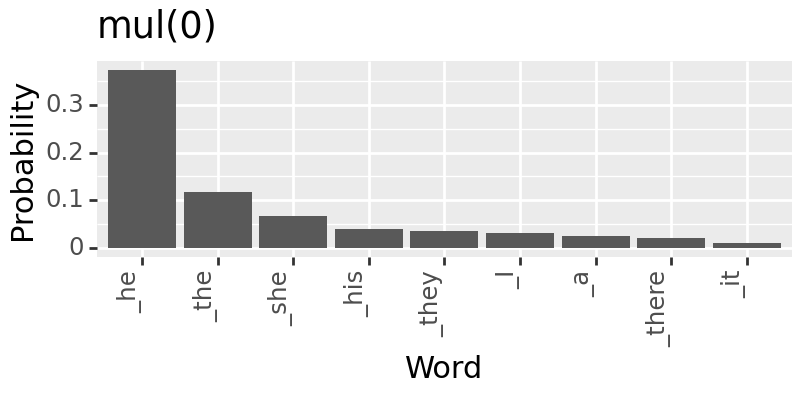

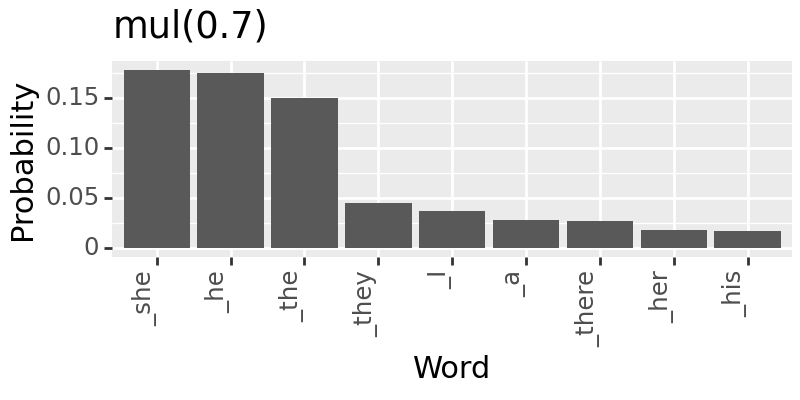

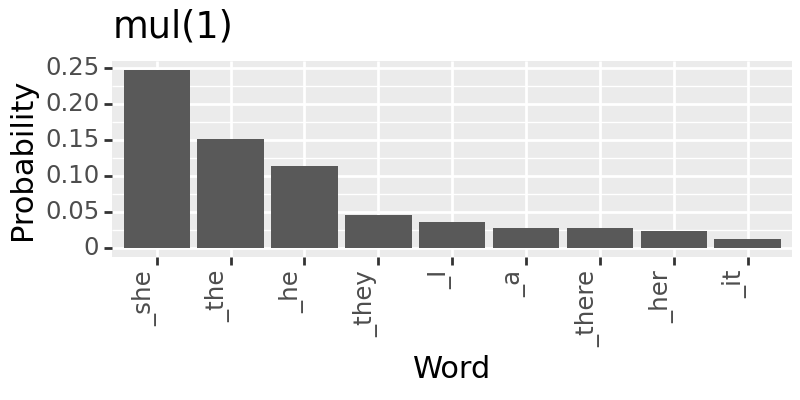

In [10]:
import torch
import pandas as pd
from plotnine import ggplot, aes, geom_bar, theme, element_text, labs

import pyvene as pv
_, tokenizer, backpack_gpt2 = pv.create_backpack_gpt2()

class MultiplierIntervention(pv.ConstantSourceIntervention):
    """Multiplier intervention"""
    
    def __init__(self, multiplier, **kwargs):
        super().__init__(**kwargs)
        self.register_buffer('multiplier', torch.tensor(multiplier))
        
    def forward(self, base, source=None, subspaces=None):
        return base * self.multiplier

    def __str__(self):
        return f"MultiplierIntervention()"

for c in [0, 0.7, 1]:
    pv_backpack_gpt2 = pv.IntervenableModel({
        "component": "sense_output",
        "intervention": MultiplierIntervention(c), "unit": "h.pos"}, 
        model=backpack_gpt2
    )
    base = tokenizer("When the nurse walked into the room,", 
                     return_tensors="pt", return_attention_mask=False)
    intervened_outputs = pv_backpack_gpt2(
        base,
        unit_locations={
            # use   pv.GET_LOC((nv, s))
            "base": pv.GET_LOC((10,2))
        }
    )
    
    # plotting
    probs = torch.nn.functional.softmax(
        intervened_outputs[1].logits[0][-1], dim=0)
    data = pv.top_vals(
        tokenizer, probs, n=9,
        return_results=True
    )
    df = pd.DataFrame(data, columns=['Word', 'Probability'])
    df['Word'] = pd.Categorical(df['Word'], categories=[x[0] for x in data], ordered=True)
    plot = (ggplot(df, aes(x='Word', y='Probability'))
            + geom_bar(stat='identity')
            + theme(axis_text_x=element_text(rotation=90, hjust=1),
                    figure_size=(4, 2))
            + labs(title=f"mul({c})")
    )
    print(plot)

### Saving and Loading
This is one of the benefits of program abstraction. We abstract out the intervention and its schema, so we have a user friendly interface. Furthermore, it allows us to have a serializable configuration file that tells everything about your configuration.

You can then save, share and load interventions easily. Note that you still need your access to the data, if you need to sample **Source** representations from other examples. But we think this is doable via a separate HuggingFace datasets upload. In the future, there could be an option of coupling this configuration with a specific remote dataset as well.

In [4]:
import torch
import pyvene as pv

_, tokenizer, gpt2 = pv.create_gpt2()

# run with new intervention type
pv_gpt2 = pv.IntervenableModel({
  "intervention_type": pv.ZeroIntervention}, 
  model=gpt2)

pv_gpt2.save("./tmp/")

loaded model
Directory './tmp/' already exists.


In [5]:
pv_gpt2 = pv.IntervenableModel.load(
    "./tmp/",
    model=gpt2)

### Multi-Source Interchange Intervention (Parallel Mode)

What is multi-source? In the examples above, interventions are at most across two examples. We support interventions across many examples. You can sample representations from two inputs, and plut them into a single **Base**.

In [61]:
import torch
import pyvene as pv

_, tokenizer, gpt2 = pv.create_gpt2()

parallel_config = pv.IntervenableConfig([
  {"layer": 3, "component": "block_output"},
  {"layer": 3, "component": "block_output"}],
  # intervene on base at the same time
  mode="parallel")
parallel_gpt2 = pv.IntervenableModel(
  parallel_config, model=gpt2)
base = tokenizer(
  "The capital of Spain is", 
  return_tensors="pt")
sources = [
  tokenizer("The language of Spain is", 
    return_tensors="pt"),
  tokenizer("The capital of Italy is", 
    return_tensors="pt")]
intervened_outputs = parallel_gpt2(
    base, sources,
    {"sources->base": (
    # each list has a dimensionality of
    # [num_intervention, batch, num_unit]
    [[[1]],[[3]]],  [[[1]],[[3]]])}
)

distrib = pv.embed_to_distrib(
    gpt2, intervened_outputs[1].last_hidden_state, logits=False)
pv.top_vals(tokenizer, distrib[0][-1], n=10)

loaded model
_the                 0.07233363389968872
_a                   0.05731499195098877
_not                 0.04443885385990143
_Italian             0.033642884343862534
_often               0.024385808035731316
_called              0.022171705961227417
_known               0.017808808013796806
_that                0.016059240326285362
_"                   0.012973357923328876
_an                  0.012878881767392159


### Multi-Source Interchange Intervention (Serial Mode)

Or you can do them sequentially, where you intervene among your **Source** examples, and get some intermediate states before merging the activations into the **Base** run.

In [91]:
config = pv.IntervenableConfig([
  {"layer": 3, "component": "block_output"},
  {"layer": 10, "component": "block_output"}],
  # intervene on base one after another
  mode="serial")
pv_gpt2 = pv.IntervenableModel(
  config, model=gpt2)
base = tokenizer(
  "The capital of Spain is", 
  return_tensors="pt")
sources = [
  tokenizer("The language of Spain is", 
    return_tensors="pt"),
  tokenizer("The capital of Italy is", 
    return_tensors="pt")]

intervened_outputs = pv_gpt2(
    base, sources,
    # intervene in serial at two positions
    {"source_0->source_1": 1, 
     "source_1->base"    : 4})

distrib = pv.embed_to_distrib(
    gpt2, intervened_outputs[1].last_hidden_state, logits=False)
pv.top_vals(tokenizer, distrib[0][-1], n=10)

_the                 0.06737838685512543
_a                   0.059834375977516174
_not                 0.04629501700401306
_Italian             0.03623826056718826
_often               0.021700192242860794
_called              0.01840786263346672
_that                0.0157712884247303
_known               0.014391838572919369
_an                  0.013535155914723873
_very                0.013022392988204956


### Multi-Source Interchange Intervention with Subspaces (Parallel Mode)

In [3]:
import torch
import pyvene as pv

_, tokenizer, gpt2 = pv.create_gpt2()

config = pv.IntervenableConfig([
    {"layer": 0, "component": "block_output",
     "subspace_partition": 
         [[0, 128], [128, 256]]}]*2,
    intervention_types=pv.VanillaIntervention,
    # act in parallel
    mode="parallel"
)
pv_gpt2 = pv.IntervenableModel(config, model=gpt2)

base = tokenizer("The capital of Spain is", return_tensors="pt")
sources = [tokenizer("The capital of Italy is", return_tensors="pt"),
          tokenizer("The capital of China is", return_tensors="pt")]

intervened_outputs = pv_gpt2(
    base, sources,
    # on same position
    {"sources->base": 4},
    # on different subspaces
    subspaces=[[[0]], [[1]]],
)

loaded model


### Multi-Source Interchange Intervention with Subspaces (Serial Mode)

In [2]:
import torch
import pyvene as pv

_, tokenizer, gpt2 = pv.create_gpt2()

config = pv.IntervenableConfig([
    {"layer": 0, "component": "block_output",
     "subspace_partition": [[0, 128], [128, 256]]},
    {"layer": 2, "component": "block_output",
     "subspace_partition": [[0, 128], [128, 256]]}],
    intervention_types=pv.VanillaIntervention,
    # act in parallel
    mode="serial"
)
pv_gpt2 = pv.IntervenableModel(config, model=gpt2)

base = tokenizer("The capital of Spain is", return_tensors="pt")
sources = [tokenizer("The capital of Italy is", return_tensors="pt"),
          tokenizer("The capital of China is", return_tensors="pt")]

intervened_outputs = pv_gpt2(
    base, sources,
    # serialized intervention
    # order is based on sources list
    {"source_0->source_1": 3, "source_1->base": 4},
    # on different subspaces
    subspaces=[[[0]], [[1]]],
)

loaded model


### Interchange Intervention Training (IIT)
Interchange intervention training (IIT) is a technique of inducing causal structures into neural models. This library naturally supports this. By training IIT, you can simply turn the gradient on for the wrapping model. In this way, your model can be trained with your interventional signals.

In [24]:
import torch
import pyvene as pv

_, tokenizer, gpt2 = pv.create_gpt2()

pv_gpt2 = pv.IntervenableModel({
    "layer": 8}, 
    model=gpt2
)

pv_gpt2.enable_model_gradients()
# run counterfactual forward as usual

loaded model


## pyvene 102
Now, you are pretty familiar with pyvene basic APIs. There are more to come. We support all sorts of weird interventions, and we encapsulate them as objects so that, even they are super weird (e.g., nested, multiple locations, different types), you can share them easily with others. BTW, if the intervention is trainable, the artifacts will be saved and shared as well.

With that, here are a couple of additional APIs.

### Grouping

You can group interventions together so that they always receive the same input when you want to use them to get activations at different places. Here is an example, where you are taking in the same **Source** example, you fetch activations twice: once in position 3 and layer 0, once in position 4 and layer 2. You don't have to pass in another dummy **Source**.

In [3]:
import torch
import pyvene as pv

_, tokenizer, gpt2 = pv.create_gpt2()

config = pv.IntervenableConfig([
    {"layer": 0, "component": "block_output", "group_key": 0},
    {"layer": 2, "component": "block_output", "group_key": 0}],
    intervention_types=pv.VanillaIntervention,
)

pv_gpt2 = pv.IntervenableModel(config, model=gpt2)

base = tokenizer("The capital of Spain is", return_tensors="pt")
sources = [tokenizer("The capital of Italy is", return_tensors="pt")]
intervened_outputs = pv_gpt2(
    base, sources, 
    {"sources->base": ([
        [[3]], [[4]] # these two are for two interventions
    ], [             # source position 3 into base position 4
        [[3]], [[4]] 
    ])}
)

loaded model


### Intervention Skipping in Runtime
You may configure a lot of interventions, but during training, not every example will have to use all of them. So, you can skip interventions for different examples differently.

In [8]:
import torch
import pyvene as pv

_, tokenizer, gpt2 = pv.create_gpt2()

config = pv.IntervenableConfig([
    # these are equivalent interventions
    # we create them on purpose
    {"layer": 0, "component": "block_output"},
    {"layer": 0, "component": "block_output"},
    {"layer": 0, "component": "block_output"}],
    intervention_types=pv.VanillaIntervention,
)
pv_gpt2 = pv.IntervenableModel(config, model=gpt2)

base = tokenizer("The capital of Spain is", return_tensors="pt")
source = tokenizer("The capital of Italy is", return_tensors="pt")
# skipping 1, 2 and 3
_, pv_out1 = pv_gpt2(base, [None, None, source],
    {"sources->base": ([None, None, [[4]]], [None, None, [[4]]])})
_, pv_out2 = pv_gpt2(base, [None, source, None],
    {"sources->base": ([None, [[4]], None], [None, [[4]], None])})
_, pv_out3 = pv_gpt2(base, [source, None, None],
    {"sources->base": ([[[4]], None, None], [[[4]], None, None])})
# should have the same results
print(
    torch.equal(pv_out1.last_hidden_state, pv_out2.last_hidden_state),
    torch.equal(pv_out2.last_hidden_state, pv_out3.last_hidden_state)
)

loaded model
True True


### Subspace Partition
You can partition your subspace before hand. If you don't, the library assumes you each neuron is in its own subspace. In this example, you partition your subspace into two continous chunk, `[0, 128), [128,256)`, which means all the neurons from index 0 upto 127 are along to partition 1. During runtime, you can intervene on all the neurons in the same parition together.

In [13]:
import torch
import pyvene as pv

_, tokenizer, gpt2 = pv.create_gpt2()

config = pv.IntervenableConfig([
    # they are linked to manipulate the same representation
    # but in different subspaces
    {"layer": 0, "component": "block_output",
     # subspaces can be partitioned into continuous chunks
     # [i, j] are the boundary indices
     "subspace_partition": [[0, 128], [128, 256]]}],
    intervention_types=pv.VanillaIntervention,
)
pv_gpt2 = pv.IntervenableModel(config, model=gpt2)

base = tokenizer("The capital of Spain is", return_tensors="pt")
source = tokenizer("The capital of Italy is", return_tensors="pt")

# using intervention skipping for subspace
intervened_outputs = pv_gpt2(
    base, [source],
    {"sources->base": 4},
    # intervene only only dimensions from 128 to 256
    subspaces=1,
)

loaded model


### Intervention Linking
Interventions can be linked to share weights and share subspaces. Here is an example of how to link interventions together. If interventions are trainable, then their weights are tied as well.

Why this is useful? it is because sometimes, you may want to intervene on different subspaces differently. Say you have a representation in a size of 512, and you hypothesize the first half represents A, and the second half represents B, you can then use the subspace intervention to test it out. With trainable interventions, you can also optimize your interventions on the same representation yet with different subspaces.

In [5]:
import torch
import pyvene as pv

_, tokenizer, gpt2 = pv.create_gpt2()

config = pv.IntervenableConfig([
    # they are linked to manipulate the same representation
    # but in different subspaces
    {"layer": 0, "component": "block_output", 
     "subspace_partition": [[0, 128], [128, 256]], "intervention_link_key": 0},
    {"layer": 0, "component": "block_output",
     "subspace_partition": [[0, 128], [128, 256]], "intervention_link_key": 0}],
    intervention_types=pv.VanillaIntervention,
)
pv_gpt2 = pv.IntervenableModel(config, model=gpt2)

base = tokenizer("The capital of Spain is", return_tensors="pt")
source = tokenizer("The capital of Italy is", return_tensors="pt")

# using intervention skipping for subspace
_, pv_out1 = pv_gpt2(
    base, [None, source],
    # 4 means token position 4
    {"sources->base": ([None, [[4]]], [None, [[4]]])},
    # 1 means the second partition in the config
    subspaces=[None, [[1]]],
)
_, pv_out2 = pv_gpt2(
    base,
    [source, None],
    {"sources->base": ([[[4]], None], [[[4]], None])},
    subspaces=[[[1]], None],
)
print(torch.equal(pv_out1.last_hidden_state, pv_out2.last_hidden_state))

# subspaces provide a list of index and they can be in any order
_, pv_out3 = pv_gpt2(
    base,
    [source, source],
    {"sources->base": ([[[4]], [[4]]], [[[4]], [[4]]])},
    subspaces=[[[0]], [[1]]],
)
_, pv_out4 = pv_gpt2(
    base,
    [source, source],
    {"sources->base": ([[[4]], [[4]]], [[[4]], [[4]]])},
    subspaces=[[[1]], [[0]]],
)
print(torch.equal(pv_out3.last_hidden_state, pv_out4.last_hidden_state))

loaded model
True
True


### Add New Model Type

In [4]:
import torch
import pyvene as pv

# get a flan-t5 from HuggingFace
from transformers import T5ForConditionalGeneration, T5Tokenizer, T5Config
config = T5Config.from_pretrained("google/flan-t5-small")
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-small")
t5 = T5ForConditionalGeneration.from_pretrained(
    "google/flan-t5-small", config=config
)

# config the intervention mapping with pv global vars
"""Only define for the block output here for simplicity"""
pv.type_to_module_mapping[type(t5)] = {
    "mlp_output": ("encoder.block[%s].layer[1]", 
                   pv.models.constants.CONST_OUTPUT_HOOK),
    "attention_input": ("encoder.block[%s].layer[0]", 
                        pv.models.constants.CONST_OUTPUT_HOOK),
}
pv.type_to_dimension_mapping[type(t5)] = {
    "mlp_output": ("d_model",),
    "attention_input": ("d_model",),
    "block_output": ("d_model",),
    "head_attention_value_output": ("d_model/num_heads",),
}

# wrap as gpt2
pv_t5 = pv.IntervenableModel({
    "layer": 0,
    "component": "mlp_output",
    "source_representation": torch.zeros(
        t5.config.d_model)
}, model=t5)

# then intervene!
base = tokenizer("The capital of Spain is", 
                 return_tensors="pt")
decoder_input_ids = tokenizer(
    "", return_tensors="pt").input_ids
base["decoder_input_ids"] = decoder_input_ids
intervened_outputs = pv_t5(
    base, 
    unit_locations={"base": 3}
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### Composing Complex Intervention Schema: Path Patching

In [6]:
import pyvene as pv

def path_patching_config(
    layer, last_layer, 
    component="head_attention_value_output", unit="h.pos"
):
    intervening_component = [
        {"layer": layer, "component": component, "unit": unit, "group_key": 0}]
    restoring_components = []
    if not component.startswith("mlp_"):
        restoring_components += [
            {"layer": layer, "component": "mlp_output", "group_key": 1}]
    for i in range(layer+1, last_layer):
        restoring_components += [
            {"layer": i, "component": "attention_output", "group_key": 1},
            {"layer": i, "component": "mlp_output", "group_key": 1}
        ]
    intervenable_config = pv.IntervenableConfig(
        intervening_component + restoring_components)
    return intervenable_config

_, tokenizer, gpt2 = pv.create_gpt2()

pv_gpt2 = pv.IntervenableModel(
    path_patching_config(4, gpt2.config.n_layer), 
    model=gpt2
)

pv_gpt2.save(
    save_directory="./tmp/"
)

loaded model
Directory './tmp/' already exists.


In [7]:
pv_gpt2 = pv.IntervenableModel.load(
    "./tmp/",
    model=gpt2)

### Composing Complex Intervention Schema: Causal Tracing in 15 lines

In [2]:
import pyvene as pv

def causal_tracing_config(
  l, c="mlp_activation", w=10, tl=48):
  s = max(0, l - w // 2)
  e = min(tl, l - (-w // 2))
  config = pv.IntervenableConfig(
    [{"component": "block_input"}] + 
    [{"layer": l, "component": c} 
      for l in range(s, e)],
    [pv.NoiseIntervention] +
    [pv.VanillaIntervention]*(e-s))
  return config

_, tokenizer, gpt2 = pv.create_gpt2()

pv_gpt2 = pv.IntervenableModel(
    causal_tracing_config(4), 
    model=gpt2
)

loaded model


### The End
Now you are graduating from pyvene 101! Feel free to take a look at our tutorials for more challenging interventions.